In [1]:
import sys
import json
import os
import tensorflow as tf
import numpy as np
#import tensorflow_probability as tfp
import numba as nb
import scipy.io
%run ./TheFmodelforPINN_KFR.ipynb
# Manually making sure the numpy random seeds are "the same" on all devices
np.random.seed(1234)
tf.random.set_seed(1234)

# LOCAL IMPORTS

eqnPath = 'DataGenerator'
sys.path.append(eqnPath)
#sys.path.append("utils")
from logger import Logger
from neuralnetwork import NeuralNetwork
from burgersutil import prep_data, plot_inf_cont_results

# %% DEFINING THE MODEL

class KFRInformedNN(NeuralNetwork):
    def __init__(self, hp, logger, X_f, ub, lb, alpha, beta, amp, x_lab=None, wn=None, sign=None):
        super().__init__(hp, logger, ub, lb)

        self.alpha = alpha
        self.beta = beta
        self.amp = amp
        self.x_lab = x_lab
        self.wn = wn
        self.sign = sign

        # Separating the collocation coordinates
        self.x_f = self.tensor(X_f[:, 0:1]) #[-1,1] random points
        self.t_f = self.tensor(X_f[:, 1:2]) #[0,1] random points

    # Defining custom loss
    def loss(self, u, u_pred):
        f_pred = self.f_model(alpha, beta, amp, x_lab, wn, sign)
        return tf.reduce_mean(tf.square(u - u_pred))  + tf.reduce_mean(tf.square(f_pred))
    
#######################################################
    def source(self, x, us, alpha, beta, amp):
        ainv = 8 * sqrt(pi * beta) * (1 + scipy.special.erf(1 / sqrt(4 * beta)))
        source = np.exp(-(x - xi(us, alpha, amp)) ** 2 / (4 * beta)) / ainv
        return source

    def flux(self, Y, us, amp, x_lab, wn, sign):
        D = Dshock(us, amp, x_lab, wn, sign)
        return 0.5 * Y ** 2. - D * Y
#######################################################
    # The actual PINN
    def f_model(self, alpha, beta, amp, x_lab, wn, sign):
        # Using the new GradientTape paradigm of TF2.0,
        # which keeps track of operations to get the gradient at runtime
        # We need the boundary conditions from the data matrix of u as well
        
        with tf.GradientTape(persistent=True) as tape:
            # Watching the two inputs we’ll need later, x and t
            tape.watch(self.x_f)
            tape.watch(self.t_f)
            # Packing together the inputs
            bc = np.zeros_like(self.x_f) #To get the predicted value of us at all times i.e. getting u_s
            X_f = tf.stack([self.x_f[:, 0], self.t_f[:, 0]], axis=1)
            BC_f = tf.stack([bc[:,0], self.t_f[:, 0]], axis=1) #predicted value of u at boundry at all times i.e. getting u_s

            # Getting the prediction
            u = self.model(X_f)
            us = self.model(BC_f)
            
            f =  self.flux(u, us, amp, x_lab, wn, sign)
            # Deriving INSIDE the tape (since we’ll need the x derivative of this later, u_xx)
            f_x = tape.gradient(f, self.x_f)
            
        s = self.source(self.x_f,us,alpha,beta,amp)    
        u_t = tape.gradient(u, self.t_f)

        # Letting the tape go
        del tape

        # Buidling the PINNs
        return u_t+f_x-s

    def predict(self, X_star):
        u_star = self.model(X_star)
        f_star = self.f_model(alpha, beta, amp, x_lab, wn, sign)
        return u_star.numpy(), f_star.numpy()

C:\Users\SZF\anaconda3\envs\GPUtensorflow\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


Hyperparameters:
{
  "N_u": 1000,
  "N_f": 14656,
  "layers": [
    2,
    45,
    45,
    45,
    45,
    45,
    45,
    45,
    45,
    45,
    1
  ],
  "tf_epochs": 450,
  "tf_lr": 0.020002,
  "tf_b1": 0.99,
  "tf_eps": null,
  "nt_epochs": 750,
  "nt_errorcheck": 1,
  "nt_lr": 0.55,
  "nt_ncorr": 98,
  "log_frequency": 10
}

TensorFlow version: 2.3.0
Eager execution: True
GPU-accerelated: True

Training started
-- Starting Adam optimization --
tf_epoch =      0  elapsed = 00:00 (+00.3)  loss = 6.7179e-01  
tf_epoch =     10  elapsed = 00:01 (+01.5)  loss = 2.1167e+00  
tf_epoch =     20  elapsed = 00:03 (+01.5)  loss = 7.0920e-02  
tf_epoch =     30  elapsed = 00:04 (+01.5)  loss = 2.7758e-02  
tf_epoch =     40  elapsed = 00:06 (+01.6)  loss = 4.9594e-02  
tf_epoch =     50  elapsed = 00:08 (+01.6)  loss = 7.8486e-02  
tf_epoch =     60  elapsed = 00:09 (+01.5)  loss = 6.2323e-02  
tf_epoch =     70  elapsed = 00:11 (+01.5)  loss = 4.9528e-02  
tf_epoch =     80  elapsed = 00:12 

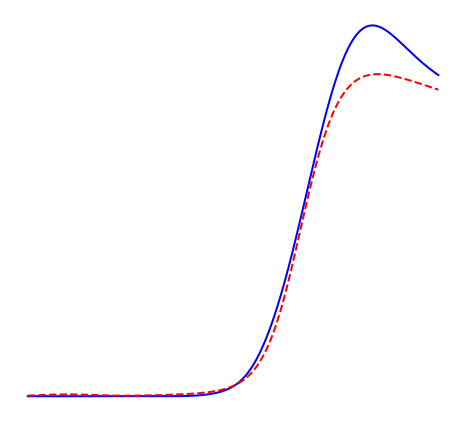

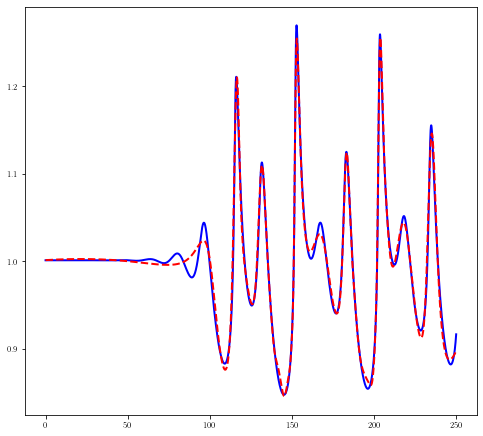

In [246]:
np.random.seed(1234)
tf.random.set_seed(1234)

hp = {}
# Data size on the solution u
hp["N_u"] = 1000
# Collocation points size, where we’ll check for f = 0
hp["N_f"] = 14656
# DeepNN topology (2-sized input [x t], 9 hidden layer of 45-width, 1-sized output [u]
neurons = 45
hidden_layers = 9
architecture = [neurons for i in range(hidden_layers+2)] #+2 to accommodate input and output
architecture[0] = 2 #Inputs
architecture[-1] = 1 #Outputs
hp["layers"] = architecture
# Setting up the TF SGD-based optimizer (set tf_epochs=0 to cancel it)
hp["tf_epochs"] = 450
hp["tf_lr"] = 0.020002
hp["tf_b1"] = 0.99
hp["tf_eps"] = None
# Setting up the quasi-newton LBGFS optimizer (set nt_epochs=0 to cancel it)
hp["nt_epochs"] = 750
hp["nt_errorcheck"] = 1 #actual epochs: epochs*errorcheck
hp["nt_lr"] = 0.55
hp["nt_ncorr"] = 98
hp["log_frequency"] = 10


alpha= 5.1
beta=0.1
amp=0.0
x_lab=None 
wn=None 
sign=None
param_value = 'amp_0alpha_5.1'



# %% TRAINING THE MODEL


# Getting the data
path = os.path.join(eqnPath, 'amp_0alpha_5.1')
x, t, X, T, Exact_u, X_star, u_star, \
    X_u_train, u_train, X_f, ub, lb = prep_data(
        path, hp["N_u"], hp["N_f"], noise=0)

# Creating the model
logger = Logger(hp)
pinn = KFRInformedNN(hp, logger, X_f, ub, lb, alpha ,beta, amp)

# Defining the error function for the logger and training
def error():
    u_pred, _ = pinn.predict(X_star)
    return np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)


# summ = pinn.summary()
# print(summ)

logger.set_error_fn(error)
pinn.fit(X_u_train, u_train)

# Getting the model predictions
u_pred, _ = pinn.predict(X_star)

#wb = pinn.wrap_training_variables()


# %% PLOTTING
plot_inf_cont_results(X_star, u_pred.flatten(), X_u_train, u_train,
                      Exact_u, X, T, x, t, save_path=None, save_hp=hp)

In [247]:
import numpy as np
from scipy.interpolate import griddata
X, T = np.meshgrid(x,t)
X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
U_pred = griddata(X_star, u_pred, (X, T), method='cubic')

In [58]:
param_value = 'amp_0alpha_5.1'
os.mkdir(param_value) #run only once for the parameter value

In [95]:
U_pred[5250,0] = U_pred[5250,1]

In [248]:
import scipy.io
import numpy as np
import tensorflow as tf
import time
import os
from pyDOE import lhs
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

respath = param_value
eqnPath = 'DataGenerator'
path = os.path.join(eqnPath, respath)
data = scipy.io.loadmat(path)

    # Flatten makes [[]] into [], [:,None] makes it a column vector
t = data['t'].flatten()[:,None] # T x 1
x = data['x'].flatten()[:,None] # N x 1

    # Keeping the 2D data for the solution data (real() is maybe to make it float by default, in case of zeroes)
Exact_u = np.real(data['u']).T # T x N

X, T = np.meshgrid(x,t)
X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))

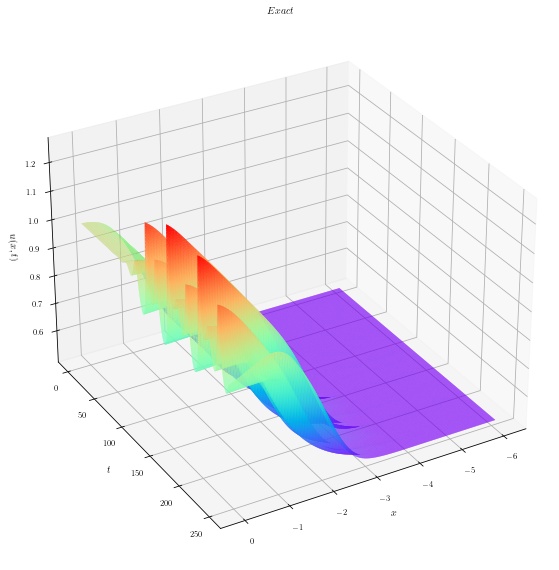

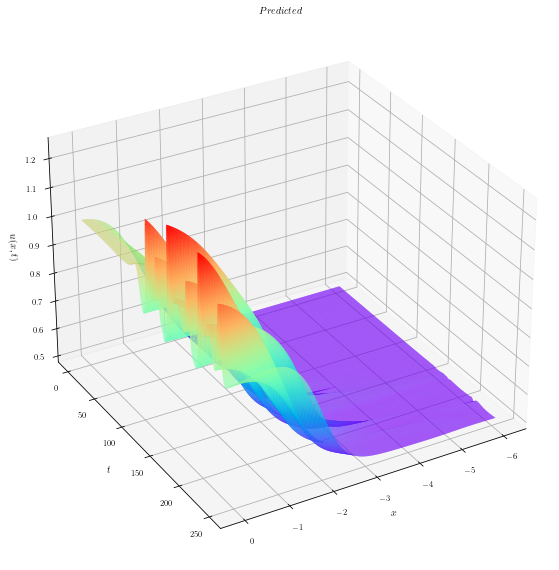

In [256]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X,T,Exact_u,rstride=2,cstride=2,cmap=cm.rainbow)
ax.view_init(30,60)
ax.set_xlabel('$x$')
ax.set_ylabel('$t$')
ax.set_zlabel('$u(x,t)$')
ax.set_title('$Exact$', fontsize = 10)

fig.savefig(respath + '/Exact.png')

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X,T,U_pred.reshape([U_pred.shape[0],-1]),rstride=2,cstride=2,cmap=cm.rainbow)
ax.view_init(30,60)
ax.set_xlabel('$x$')
ax.set_ylabel('$t$')
ax.set_zlabel('$u(x,t)$')
ax.set_title('$Predicted$', fontsize = 10)

fig.savefig(respath + '/Predicted.png')

In [249]:
s=U_pred.reshape([U_pred.shape[0],-1])

No handles with labels found to put in legend.


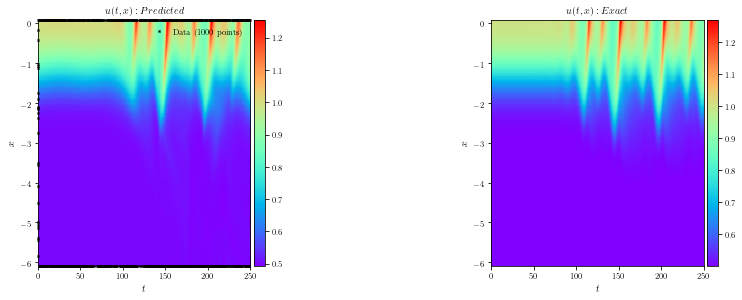

In [251]:
from plotting import newfig, savefig, saveResultDir
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from scipy.interpolate import griddata
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable


#   # Creating the figures
fig, ax = newfig(2.5, 1.5)
# ax.axis('off')

####### Row 0: u(t,x) ##################    
gs0 = gridspec.GridSpec(1, 3)
gs0.update(top=1-0.06, bottom=1-1/3, left=0.15, right=0.85, wspace=0)
ax = plt.subplot(gs0[:, 0])

h = ax.imshow(s.T, interpolation='nearest', cmap='rainbow', 
             extent=[t.min(), t.max(), x.min(), x.max()], 
             origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)

ax.plot(X_u_train[:,1], X_u_train[:,0], 'kx', label = 'Data (%d points)' % (u_train.shape[0]), markersize = 2, clip_on = False)

line = np.linspace(x.min(), x.max(), 2)[:,None]
#ax.plot(t[25]*np.ones((2,1)), line, 'w-', linewidth = 1)
#ax.plot(t[50]*np.ones((2,1)), line, 'w-', linewidth = 1)
#ax.plot(t[75]*np.ones((2,1)), line, 'w-', linewidth = 1)    

ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.legend(frameon=False, loc = 'best')
ax.set_title('$u(t,x): Predicted$', fontsize = 10)
#fig.savefig(respath +'/ColorMap.png')

ax = plt.subplot(gs0[:, 2])
#fig, ax = newfig(1.5, 1.5)
h = ax.imshow(Exact_u.T, interpolation='nearest', cmap='rainbow', 
             extent=[t.min(), t.max(), x.min(), x.max()], 
             origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)
h

ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.legend(frameon=False, loc = 'best')
ax.set_title('$u(t,x): Exact$', fontsize = 10)
fig.savefig(respath +'/ColorMap1.png')

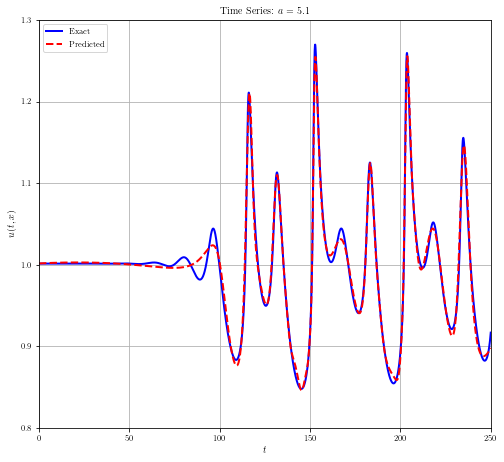

In [252]:
fig, ax = newfig(1.5, 1.5)  
ax.plot(t,Exact_u[:,-1], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(t,U_pred[:,-1], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$t$')
ax.set_ylabel('$u(t,x)$')    
ax.set_title('Time Series: $a=5.1$', fontsize = 10)
ax.set_xlim([0,250])
ax.set_ylim([0.8,1.3])
ax.grid()
plt.legend(["Exact", "Predicted"], loc ="upper left")

fig.savefig(respath + '/TimeSeries1.png')

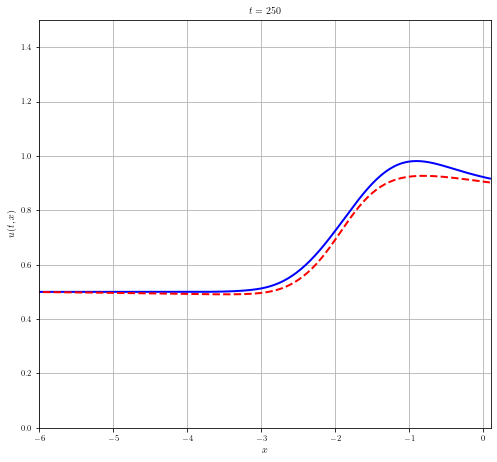

In [23]:
fig, ax = newfig(1.5,1.5)
ax.plot(x,Exact_u[-1,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[-1,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
# ax.axis('square')
ax.set_xlim([-6,0.1])
ax.set_ylim([0,1.5])    
ax.set_title('$t = 250$', fontsize = 10)
ax.grid()
fig.savefig(respath + '/SpatialResult2.png')

In [169]:
from scipy.io import savemat

matDict = {"t": T, "x": X, "u": U_pred}

filename = f'amp_{amp}' + f'alpha_{alpha}' + 'predicted'
savemat(filename + '.mat', matDict)

In [170]:
data = scipy.io.loadmat('amp_0.0alpha_4.85predicted')

In [177]:
tp = data['t'] # T x 1
xp = data['x'] # N x 1

    # Keeping the 2D data for the solution data (real() is maybe to make it float by default, in case of zeroes)
u_p = np.real(data['u']) # T x N

In [173]:
%run ./utils.ipynb

TypeError: cannot unpack non-iterable NoneType object

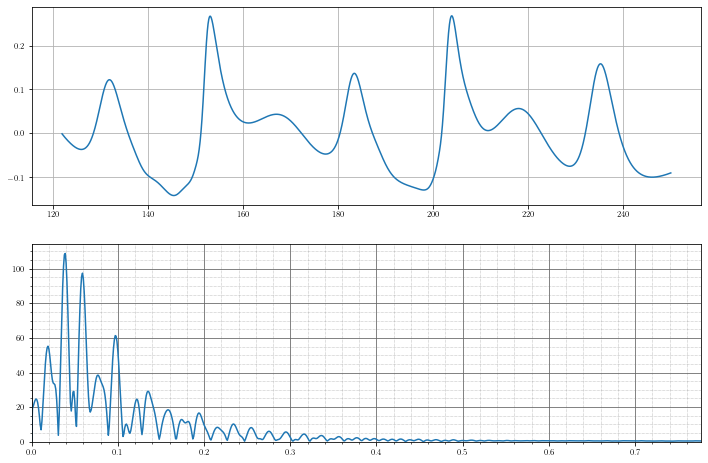

In [253]:
data = [t[2550:-1], U_pred[2550:-1,-1]]
data = np.array(data)
data=data.reshape(2,-1)
data=data.T

f, y = power_spectrum(tus=data, plot=True, t_min=0, t_max=250, M=1000, df=0.001)

TypeError: cannot unpack non-iterable NoneType object

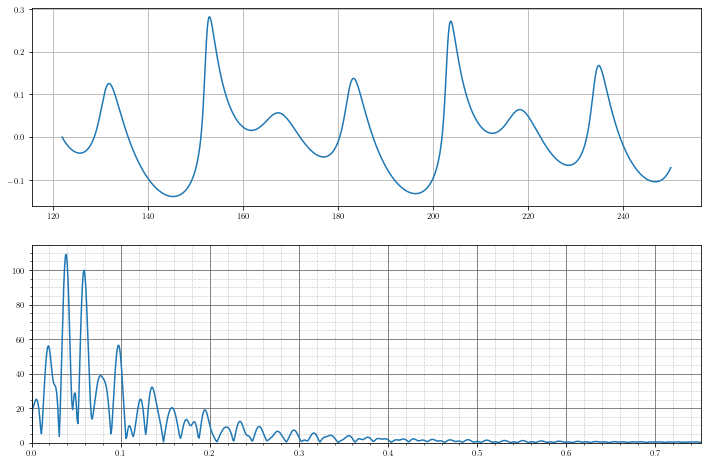

In [254]:
data = [t[2550:-1], np.array([Exact_u[2550:-1,-1]]).T]
data = np.array(data)
data=data.reshape(2,-1)
data=data.T

f, y = power_spectrum(tus=data, plot=True, t_min=0, t_max=250, M=1000, df=0.001)